In [55]:
library(rnaturalearth)
library(rnaturalearthdata)
library(dplyr)
library(tidyr)
library(geosphere)
library(ggplot2)
library(maps)
library(sf)

In [56]:
caracteristiques <- read.csv("caracteristique_drone.csv", stringsAsFactors = FALSE)
bases_lancement <- read.csv("bases_lancement.csv", stringsAsFactors = FALSE)

In [57]:
# Création du dataframe des villes ukrainiennes les plus touchées par les drones Shahed
villes_ukrainiennes <- data.frame(
  nom = c("Kyiv", "Dnipro", "Kharkiv", "Odesa", "Kryvyï Rih", "Zaporijia",
          "Kramatorsk", "Pavlohrad", "Okhtyrka", "Ouzyn", "Yahotyn", "Ternopil", "Buryn",
          "Cherkasy", "Kodra", "Nizhyn", "Dibrivne"),
  lat = c(50.4501, 48.4647, 49.9935, 46.4825, 47.9073, 47.8252,
          48.7233, 48.5208, 50.3121, 49.7965, 50.2623, 49.5486, 49.5909,
          49.4875, 50.5660, 51.0480, 50.4826),  # Arrondi à 4 décimales
  long = c(30.5234, 35.0462, 36.2502, 30.7233, 33.3850, 35.1683,
           37.5783, 35.8790, 34.8986, 30.3244, 31.7689, 25.6458, 25.5609,
           31.9752, 29.5638, 31.9355, 33.5608)  # Arrondi à 4 décimales
)

bases_russes <- bases_lancement %>%
  select(Latitude, Longitude)

In [58]:
line_front_1 <- data.frame(
  lat = c(48.532826797664846, 50.07933496745732),
  long = c(38.45637663250045, 37.7658438650635)
)

line_front_2 <- data.frame(
  lat = c(46.434198799864376, 48.532826797664846),
  long = c(32.1672572599026, 38.45637663250045)
)

line_front_3 <- data.frame(
  lat = c(50.07933496745732, 50.92405887999426),
  long = c(37.7658438650635, 34.73281464092588)
)

line_front_4 <- data.frame(
  lat = c(50.92405887999426, 52.2874298771795),
  long = c(34.73281464092588, 33.2228480040779)
)

line_front_5 <- data.frame(
  lat = c(52.2874298771795, 51.36480437280772),
  long = c(33.2228480040779, 28.681296931138895)
)

line_front_6 <- data.frame(
  lat = c(51.36480437280772, 51.633903542920415),
  long = c(28.681296931138895, 23.804251089502966)
)

line_front_7 <- data.frame(
  lat = c(51.633903542920415, 48.35732598510753),
  long = c(23.804251089502966, 22.427459199975896)
)

line_front_8 <- data.frame(
  lat = c(48.35732598510753, 48.078730771810925),
  long = c(22.427459199975896, 29.422670952108504)
)

line_front_9 <- data.frame(
  lat = c(48.078730771810925, 45.30127917139041),
  long = c(29.422670952108504, 28.414621049701758)
)

line_front_10 <- data.frame(
  lat = c(45.30127917139041, 46.434198799864376),
  long = c(28.414621049701758, 32.1672572599026)
)


# List of all fronts in the correct order for polygon construction
front_lines <- list(
  line_front_1,
  line_front_2,
  line_front_3,
  line_front_4,
  line_front_5,
  line_front_6,
  line_front_7,
  line_front_8,
  line_front_9,
  line_front_10
)

# Combine all lines into segments for polygon construction
border_segments <- lapply(front_lines, function(line) {
  st_linestring(as.matrix(line))
})

In [59]:
# Constante de latitude et longitude pour séparer les zones
latitude_limite <- 48.532826797664846
limiteLongitude <- 33

Fonction pour la génération des trajectoires

In [60]:
interpolate_points <- function(lat_start, lon_start, lat_end, lon_end, interval_km = 2) {
  dist_total <- distHaversine(c(lon_start, lat_start), c(lon_end, lat_end))
  num_points <- ceiling(dist_total / (interval_km * 1000))
  interpolated_coords <- geosphere::gcIntermediate(
    c(lon_start, lat_start), c(lon_end, lat_end),
    n = num_points, addStartEnd = TRUE, breakAtDateLine = FALSE
  )
  data.frame(lat = interpolated_coords[,2], long = interpolated_coords[,1])
}

In [61]:
# Fonction principale pour simuler les trajectoires des drones
simulate_trajectories <- function(nombre_drones, caracteristiques, bases_russes, villes_ukrainiennes, line_front_1, line_front_2, line_front_3, line_front_4, latitude_limite, limiteLongitude, interpolate_points) {
  trajectoires <- data.frame()
  
  for (i in 1:nombre_drones) {
    drone_id <- paste0("Drone_", i)
    drone <- select_random_drone(caracteristiques)
    
    if (runif(1) < 0.5) {
      # Drones russes
      trajectoire <- simulate_russian_drone(i, drone, bases_russes, line_front_1, line_front_2, line_front_3, line_front_4, villes_ukrainiennes, latitude_limite, limiteLongitude, interpolate_points, drone_id)
    } else {
      # Drones ukrainiens
      trajectoire <- simulate_ukrainian_drone(i, drone, villes_ukrainiennes, bases_russes, line_front_1, line_front_2, line_front_3, line_front_4, latitude_limite, limiteLongitude, interpolate_points, drone_id)
    }
    
    trajectoires <- rbind(trajectoires, trajectoire)
  }
  
  return(trajectoires)
}

In [62]:
# Fonction pour sélectionner un drone aléatoire
select_random_drone <- function(caracteristiques) {
  return(caracteristiques[sample(nrow(caracteristiques), 1), ])
}

In [63]:
# Fonction pour simuler un drone russe
simulate_russian_drone <- function(i, drone, bases_russes, line_front_1, line_front_2, line_front_3, line_front_4, villes_ukrainiennes, latitude_limite, limiteLongitude, interpolate_points, drone_id) {
  base_lancement <- bases_russes[sample(nrow(bases_russes), 1), ]
  lat_depart <- base_lancement$Latitude
  long_depart <- base_lancement$Longitude
  origine <- "Russe"
  
  if (lat_depart >= latitude_limite) {
    # Drones partant du nord
    if (drone$Type == "Suicide") {
      cible <- villes_ukrainiennes[villes_ukrainiennes$lat >= latitude_limite, ][sample(nrow(villes_ukrainiennes[villes_ukrainiennes$lat >= latitude_limite, ]), 1), ]
      return(generate_suicide_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, cible$lat, cible$long, interpolate_points))
    } else {
      chosen_front <- sample(c("line_front_1", "line_front_3", "line_front_4"), size = 1, prob = c(0.5, 0.25, 0.25))
      front <- get(chosen_front)
      return(generate_patrol_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, front, interpolate_points))
    }
  } else {
    # Drones partant du sud
    if (drone$Type == "Suicide") {
      cible <- villes_ukrainiennes[villes_ukrainiennes$lat < latitude_limite, ][sample(nrow(villes_ukrainiennes[villes_ukrainiennes$lat < latitude_limite, ]), 1), ]
      return(generate_suicide_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, cible$lat, cible$long, interpolate_points))
    } else {
      return(generate_patrol_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, line_front_2, interpolate_points))
    }
  }
}

In [64]:
# Fonction pour simuler un drone ukrainien
simulate_ukrainian_drone <- function(i, drone, villes_ukrainiennes, bases_russes, line_front_1, line_front_2, line_front_3, line_front_4, latitude_limite, limiteLongitude, interpolate_points, drone_id) {
  ville_depart <- villes_ukrainiennes[villes_ukrainiennes$long > limiteLongitude, ][sample(nrow(villes_ukrainiennes[villes_ukrainiennes$long > limiteLongitude, ]), 1), ]
  lat_depart <- ville_depart$lat
  long_depart <- ville_depart$long
  origine <- "Ukrainien"
  
  if (lat_depart >= latitude_limite) {
    if (drone$Type == "Suicide") {
      cible <- bases_russes[bases_russes$Latitude >= latitude_limite, ][sample(nrow(bases_russes[bases_russes$Latitude >= latitude_limite, ]), 1), ]
      return(generate_suicide_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, cible$Latitude, cible$Longitude, interpolate_points))
    } else {
      chosen_front <- sample(c("line_front_1", "line_front_3", "line_front_4"), size = 1, prob = c(0.5, 0.25, 0.25))
      front <- get(chosen_front)
      return(generate_patrol_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, front, interpolate_points, invert_direction = TRUE))
    }
  } else {
    if (drone$Type == "Suicide") {
      cible <- bases_russes[bases_russes$Latitude < latitude_limite, ][sample(nrow(bases_russes[bases_russes$Latitude < latitude_limite, ]), 1), ]
      return(generate_suicide_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, cible$Latitude, cible$Longitude, interpolate_points))
    } else {
      return(generate_patrol_trajectory(drone_id, i, drone$Type, origine, lat_depart, long_depart, line_front_2, interpolate_points, invert_direction = TRUE))
    }
  }
}

In [65]:
# Fonction pour générer une trajectoire de type suicide
generate_suicide_trajectory <- function(drone_id, iteration, drone_type, origine, lat_depart, long_depart, lat_arrivee, long_arrivee, interpolate_points) {
  trajectoire <- interpolate_points(lat_depart, long_depart, lat_arrivee, long_arrivee)
  return(cbind(data.frame(Drone_ID = drone_id, Drone_Type = drone_type, Origine = origine, Segment = "Suicide", Iteration = iteration), trajectoire))
}

In [66]:
# Fonction pour générer une trajectoire de patrouille
generate_patrol_trajectory <- function(drone_id, iteration, drone_type, origine, lat_depart, long_depart, line_front, interpolate_points, invert_direction = FALSE) {
  t <- runif(1)
  lat_debut_patrouille <- line_front$lat[1] + t * (line_front$lat[2] - line_front$lat[1]) + runif(1, -0.01, 0.01)
  long_debut_patrouille <- line_front$long[1] + t * (line_front$long[2] - line_front$long[1]) + runif(1, -0.01, 0.01)
  
  dx <- line_front$long[2] - line_front$long[1]
  dy <- line_front$lat[2] - line_front$lat[1]
  norm <- sqrt(dx^2 + dy^2)
  ux <- dx / norm
  uy <- dy / norm

  angle <- runif(1, 0, 180) * pi / 180
  if (invert_direction) {
    ux <- -ux
    uy <- -uy
  }

  ux_patrouille <- cos(angle) * ux - sin(angle) * uy
  uy_patrouille <- sin(angle) * ux + cos(angle) * uy

  distance_patrouille <- runif(1, 0.3, 1)
  lat_fin_patrouille <- lat_debut_patrouille + uy_patrouille * distance_patrouille
  long_fin_patrouille <- long_debut_patrouille + ux_patrouille * distance_patrouille

  trajectoire_allee <- interpolate_points(lat_depart, long_depart, lat_debut_patrouille, long_debut_patrouille)
  trajectoire_allee <- cbind(data.frame(Segment = "Allée", Drone_ID = drone_id, Drone_Type = drone_type, Origine = origine, Iteration = iteration), trajectoire_allee)

  trajectoire_patrouille <- interpolate_points(lat_debut_patrouille, long_debut_patrouille, lat_fin_patrouille, long_fin_patrouille)
  trajectoire_patrouille <- cbind(data.frame(Segment = "Patrouille", Drone_ID = drone_id, Drone_Type = drone_type, Origine = origine, Iteration = iteration), trajectoire_patrouille)

  trajectoire_retour <- interpolate_points(lat_fin_patrouille, long_fin_patrouille, lat_depart, long_depart)
  trajectoire_retour <- cbind(data.frame(Segment = "Retour", Drone_ID = drone_id, Drone_Type = drone_type, Origine = origine, Iteration = iteration), trajectoire_retour)

  return(rbind(trajectoire_allee, trajectoire_patrouille, trajectoire_retour))
}

In [67]:
# Fonction pour générer la vitesse d'un drone
generate_speed <- function(type_drone, origine) {
  # Définir les vitesses de croisière et les vitesses maximales
  if (origine == "Russe") {
    if (type_drone == "Suicide") {
      vitesse_croisiere <- 100  # Vitesse de croisière pour un drone Suicide russe
      vitesse_max <- 150  # Vitesse maximale pour un drone Suicide russe
    } else if (type_drone == "Reconnaissance") {
      vitesse_croisiere <- 120  # Vitesse de croisière pour un drone Reconnaissance russe
      vitesse_max <- 180  # Vitesse maximale pour un drone Reconnaissance russe
    }
  } else if (origine == "Ukrainien") {
    if (type_drone == "Suicide") {
      vitesse_croisiere <- 90  # Vitesse de croisière pour un drone Suicide ukrainien
      vitesse_max <- 130  # Vitesse maximale pour un drone Suicide ukrainien
    } else if (type_drone == "Reconnaissance") {
      vitesse_croisiere <- 110  # Vitesse de croisière pour un drone Reconnaissance ukrainien
      vitesse_max <- 160  # Vitesse maximale pour un drone Reconnaissance ukrainien
    }
  }

  # Définir un écart-type pour la variabilité de la vitesse (10% de la vitesse de croisière)
  ecart_type <- vitesse_croisiere * 0.1  # Variabilité de 10% autour de la vitesse de croisière
  
  # Générer une vitesse selon une loi normale autour de la vitesse de croisière
  vitesse <- rnorm(1, mean = vitesse_croisiere, sd = ecart_type)
  
  # Appliquer les contraintes de vitesse
  vitesse <- max(vitesse, 0.8 * vitesse_croisiere)  # La vitesse ne doit pas être inférieure à 20% de la vitesse de croisière
  vitesse <- min(vitesse, vitesse_max)  # La vitesse ne doit pas dépasser la vitesse maximale
  
  return(vitesse)
}

In [68]:
# Fonction pour générer l'altitude d'un drone
generate_altitude <- function(type_drone, origine, altitude_max, altitude_min) {
  # Définir l'altitude cible autour de 20% en dessous de l'altitude maximale
  altitude_cible <- altitude_max * 0.8  # 20% sous l'altitude maximale

  # Définir un écart-type pour la variabilité de l'altitude (10% de l'altitude cible)
  ecart_type <- altitude_cible * 0.1  # Variabilité de 10% autour de l'altitude cible
  
  # Générer une altitude selon une loi normale autour de l'altitude cible
  altitude <- rnorm(1, mean = altitude_cible, sd = ecart_type)
  
  # Appliquer les contraintes d'altitude
  altitude <- max(altitude, altitude_min)  # L'altitude ne doit pas être inférieure à l'altitude minimale
  altitude <- min(altitude, altitude_max)  # L'altitude ne doit pas dépasser l'altitude maximale
  
  return(altitude)
}

In [69]:
# Fonction pour calculer la distance entre deux points en km
calculate_distance <- function(lat1, lon1, lat2, lon2) {
  R <- 6371  # Rayon moyen de la Terre en km
  delta_lat <- (lat2 - lat1) * pi / 180
  delta_lon <- (lon2 - lon1) * pi / 180
  a <- sin(delta_lat / 2)^2 + cos(lat1 * pi / 180) * cos(lat2 * pi / 180) * sin(delta_lon / 2)^2
  c <- 2 * atan2(sqrt(a), sqrt(1 - a))
  return(R * c)
}

In [74]:
# Simulation des trajectoires
set.seed(123)
trajectoires <- simulate_trajectories(nombre_drones = 1000, caracteristiques = caracteristiques, bases_russes = bases_russes, 
                                      villes_ukrainiennes = villes_ukrainiennes, line_front_1 = line_front_1, line_front_2 = line_front_2, 
                                      line_front_3 = line_front_3, line_front_4 = line_front_4, 
                                      latitude_limite = latitude_limite, limiteLongitude = limiteLongitude, interpolate_points = interpolate_points)

# Ajout des vitesses et altitudes aux trajectoires
trajectoires <- trajectoires %>%
  left_join(caracteristiques, by = c("Drone_Type" = "Type", "Origine" = "Origine")) %>%
  mutate(
    Vitesse = mapply(generate_speed, Drone_Type, Origine),
    Altitude = mapply(generate_altitude, Drone_Type, Origine, Altitudemax, Altitudemin)
  ) %>%
  select(-Altitudemax, -Altitudemin, -Vitessemax, -Portee.km., -Cruisespeed, -Porteeusuelle) %>%
  group_by(Drone_ID) %>%  # Calcul par drone
  mutate(
    # Calcul de la distance cumulée
    Distance_Cumulee = cumsum(
      c(0, mapply(calculate_distance, lat[-n()], long[-n()], lat[-1], long[-1]))
    ),
    # Temps écoulé en heures
    Temps_Ecoule = Distance_Cumulee / Vitesse
  ) %>%
  ungroup()

# Afficher les premières lignes des trajectoires complètes
head(trajectoires)

Drone_ID,Drone_Type,Origine,Segment,Iteration,lat,long,Nom,Vitesse,Altitude,Distance_Cumulee,Temps_Ecoule
<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Drone_1,Suicide,Ukrainien,Suicide,1,47.90730,33.38500,Babor,88.62709,278.1377,0.000000,0.00000000
Drone_1,Suicide,Ukrainien,Suicide,1,47.88950,33.38609,Babor,93.31744,336.6183,1.980528,0.02122356
Drone_1,Suicide,Ukrainien,Suicide,1,47.87171,33.38717,Babor,79.59781,335.8515,3.961056,0.04976339
Drone_1,Suicide,Ukrainien,Suicide,1,47.85391,33.38826,Babor,93.76041,341.9991,5.941585,0.06336986
Drone_1,Suicide,Ukrainien,Suicide,1,47.83611,33.38935,Babor,101.74465,342.3228,7.922113,0.07786269
Drone_1,Suicide,Ukrainien,Suicide,1,47.81832,33.39043,Babor,106.17041,354.6104,9.902641,0.09327120


Filtrage des données hors des frontières

[1] "Conversion des trajectoires en sf réussie..."
[1] "Création du polygone mis à jour réussie..."
[1] "Ajout de la colonne `within_updated` réussi..."
[1] "Carte générée avec succès..."
[1] "Sauvegarde du CSV réussie..."


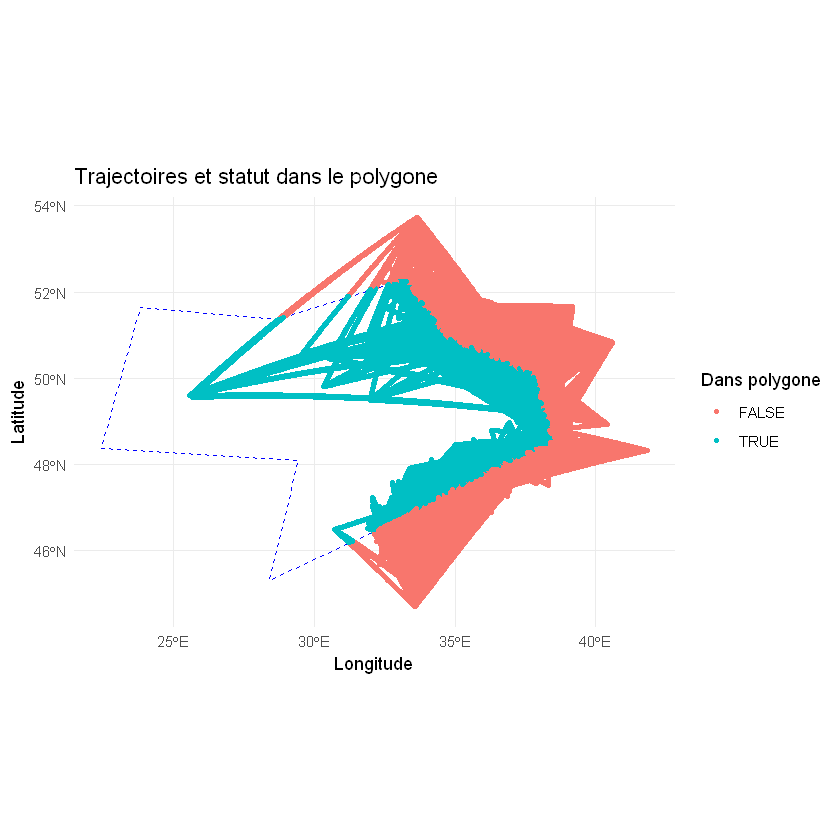

In [71]:
trajectoires_sf <- st_as_sf(trajectoires, coords = c("long", "lat"), crs = 4326) %>%
  mutate(
    long = st_coordinates(geometry)[, 1],  # Extraire la longitude
    lat = st_coordinates(geometry)[, 2]   # Extraire la latitude
  )

print("Conversion des trajectoires en sf réussie...")

line_front_1_updated <- st_linestring(matrix(c(38.45637663250045, 48.532826797664846,
                                               37.7658438650635, 50.07933496745732), ncol = 2, byrow = TRUE))
line_front_2_updated <- st_linestring(matrix(c(32.1672572599026, 46.434198799864376,
                                               38.45637663250045, 48.532826797664846), ncol = 2, byrow = TRUE))
line_front_3_updated <- st_linestring(matrix(c(37.7658438650635, 50.07933496745732,
                                               34.73281464092588, 50.92405887999426), ncol = 2, byrow = TRUE))
line_front_4_updated <- st_linestring(matrix(c(34.73281464092588, 50.92405887999426,
                                               33.2228480040779, 52.2874298771795), ncol = 2, byrow = TRUE))
line_front_5_updated <- st_linestring(matrix(c(33.2228480040779, 52.2874298771795,
                                               28.681296931138895, 51.36480437280772), ncol = 2, byrow = TRUE))
line_front_6_updated <- st_linestring(matrix(c(28.681296931138895, 51.36480437280772,
                                               23.804251089502966, 51.633903542920415), ncol = 2, byrow = TRUE))
line_front_7_updated <- st_linestring(matrix(c(23.804251089502966, 51.633903542920415,
                                               22.427459199975896, 48.35732598510753), ncol = 2, byrow = TRUE))
line_front_8_updated <- st_linestring(matrix(c(22.427459199975896, 48.35732598510753,
                                               29.422670952108504, 48.078730771810925), ncol = 2, byrow = TRUE))
line_front_9_updated <- st_linestring(matrix(c(29.422670952108504, 48.078730771810925,
                                               28.414621049701758, 45.30127917139041), ncol = 2, byrow = TRUE))
line_front_10_updated <- st_linestring(matrix(c(28.414621049701758, 45.30127917139041,
                                                32.1672572599026, 46.434198799864376), ncol = 2, byrow = TRUE))
# Combinez toutes les lignes
front_lines_updated <- st_sfc(list(line_front_1_updated, line_front_2_updated, line_front_3_updated, line_front_4_updated, line_front_5_updated, line_front_6_updated, line_front_7_updated, line_front_8_updated, line_front_9_updated, line_front_10_updated), crs = 4326)
front_polygon_updated <- st_union(front_lines_updated) %>% st_cast("POLYGON")

print("Création du polygone mis à jour réussie...")

# Vérifier si les points sont dans le polygone
trajectoires_sf <- trajectoires_sf %>%
  mutate(within_updated = lengths(st_within(geometry, front_polygon_updated)) > 0)

print("Ajout de la colonne `within_updated` réussi...")

# Visualiser avec ggplot2
ggplot() +
  geom_sf(data = front_polygon_updated, fill = NA, color = "blue", linetype = "dashed") +
  geom_sf(data = trajectoires_sf, aes(color = within_updated), size = 1) +
  labs(title = "Trajectoires et statut dans le polygone",
       color = "Dans polygone",
       x = "Longitude",
       y = "Latitude") +
  theme_minimal()

print("Carte générée avec succès...")

# Sauvegarder le CSV mis à jour
write.csv(st_drop_geometry(trajectoires_sf), "trajectoires_drones_with_TRUE_FALSE.csv", row.names = FALSE)
trajectoires_sf <- read.csv("trajectoires_drones_with_TRUE_FALSE.csv")
print("Sauvegarde du CSV réussie...")

In [72]:
trajectoires_for_classification <- trajectoires_sf %>%
    filter(within_updated == "TRUE")
write.csv(trajectoires_for_classification, "trajectoires_drones_only_within_polygon.csv")
head(trajectoires_for_classification)

,Drone_ID,Drone_Type,Origine,Segment,Iteration,Nom,Vitesse,Altitude,Distance_Cumulee,Temps_Ecoule,long,lat,within_updated
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,88.62709,278.1377,0.000000,0.00000000,33.38500,47.90730,TRUE
2,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,93.31744,336.6183,1.980528,0.02122356,33.38609,47.88950,TRUE
3,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,79.59781,335.8515,3.961056,0.04976339,33.38717,47.87171,TRUE
4,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,93.76041,341.9991,5.941585,0.06336986,33.38826,47.85391,TRUE
5,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,101.74465,342.3228,7.922113,0.07786269,33.38935,47.83611,TRUE
6,Drone_1,Suicide,Ukrainien,Suicide,1,Babor,106.17041,354.6104,9.902641,0.09327120,33.39043,47.81832,TRUE
